# DATA301 Project Phase 2

This is my notebook for phase 2 of my project for DATA301.

In it I will go through all the stages of loading in the data, cleaning and preprocessing it, examining the features, and finally producing the best model I can for my fitted data

### Part 1 - Loading

In this part I will load all the required libraries, as well as the required datasets

Loading the libraries

In [20]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

Now we will load all the datasets that we want to use
1. Body Measures - https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.htm
2. Blood Pressure - https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BPX_J.htm
3. Cardiovasular Health - https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/CDQ_J.htm
4. Demographics - https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm
5. Medical Conditions - https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/MCQ_J.htm

In [21]:
body_measures = pd.read_sas('data\BMX_J.XPT')
blood_pressure = pd.read_sas('data\BPX_J.XPT')
cardio_health = pd.read_sas('data\CDQ_J.XPT')
demographics = pd.read_sas('data\DEMO_J.XPT')
medical_conditions = pd.read_sas('data\MCQ_J.XPT')

Now we need to drop several columns.

#### Body Measures Dataset

For our first dataset, the body measures one, there are only 4 columns that we are interested in from looking at the documentation (https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BMX_J.htm), which would be the SEQN, weight, height, and BMI, and the rest seem unneccesary so we will exclude them.

In [22]:
body_measures_short = body_measures[['SEQN', 'BMXWT', 'BMXHT', 'BMXBMI']]
body_measures_short.columns = ['SEQN', 'Weight', 'Height', 'BMI']
print(body_measures_short.head())

print('Total number of respondents')
print(len(body_measures_short))
print('% NaN occurrences in Columns:')
print(100 * body_measures_short.isnull().sum(axis = 0)/len(body_measures_short))

      SEQN  Weight  Height   BMI
0  93703.0    13.7    88.6  17.5
1  93704.0    13.9    94.2  15.7
2  93705.0    79.5   158.3  31.7
3  93706.0    66.3   175.7  21.5
4  93707.0    45.4   158.4  18.1
Total number of respondents
8704
% NaN occurrences in Columns:
SEQN      0.000000
Weight    1.424632
Height    7.904412
BMI       8.030790
dtype: float64


We can see that of the columns we have selected, they have very few NA values in them which means that we can be happy using them for now

#### Blood Pressure Dataset

For our second dataset, the blood pressure one, there are several unneccessary columns. From reading the documentation (https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/BPX_J.htm), we can see that there are columns about cuff size, and which arm the measurement was taken on, but we are only interested in the recorded blood pressure and the resting heart rate. Since the blood pressure was measured 4 consecutive times, we are going to take an average of the four as our resulting blood pressures, and keep these along with their 60 second heart rate. But first, we need to check if any of these columns have high occurrences of NAs, as they will affect the output

In [23]:
print('Total number of respondents')
print(len(blood_pressure))
print('% NaN occurrences in Columns:')
print(100 * blood_pressure.isnull().sum(axis = 0)/len(blood_pressure))

Total number of respondents
8704
% NaN occurrences in Columns:
SEQN         0.000000
PEASCCT1    94.898897
BPXCHR      82.318474
BPAARM      21.679688
BPACSZ      21.737132
BPXPLS      22.541360
BPXPULS      4.859835
BPXPTY      22.541360
BPXML1      22.667739
BPXSY1      27.596507
BPXDI1      27.596507
BPAEN1      27.596507
BPXSY2      24.597886
BPXDI2      24.597886
BPAEN2      24.597886
BPXSY3      24.885110
BPXDI3      24.885110
BPAEN3      24.885110
BPXSY4      93.612132
BPXDI4      93.612132
BPAEN4      93.612132
dtype: float64


Most of the columns that we want to use have about 25% of reponses that are NAs, which is okay for our purposes. However, the fourth reading has 93% NA responses, so we will exclude it from our calculations and just use the first 3 readings of the blood pressures

In [24]:
blood_pressure['diastolic_avg'] = blood_pressure[['BPXDI1', 'BPXDI2', 'BPXDI3']].mean(axis=1, skipna=False)
blood_pressure['systolic_avg'] = blood_pressure[['BPXSY1', 'BPXSY2', 'BPXSY3']].mean(axis=1, skipna=False)
blood_pressure['pulse_rate_BPM'] = blood_pressure['BPXPLS']
blood_pressure_short = blood_pressure[['SEQN', 'diastolic_avg', 'systolic_avg', 'pulse_rate_BPM']]
print(blood_pressure_short.head())
print(len(blood_pressure_short[blood_pressure_short.isna().any(axis=1)]))
print(len(blood_pressure_short))

      SEQN  diastolic_avg  systolic_avg  pulse_rate_BPM
0  93703.0            NaN           NaN             NaN
1  93704.0            NaN           NaN             NaN
2  93705.0            NaN           NaN            52.0
3  93706.0      73.333333    111.333333            82.0
4  93707.0      47.333333    128.000000           100.0
2627
8704


From this we can see that there are now around 20% of responses that have an NA in one or more of these columns, which is an acceptable number, and we will deal with these later.

#### Cardiovascular Health Dataset

Next we are going to take a look at the cardiovascular health dataset, and see if there are any columns which need to be dropped. Referring to the documentation, https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/CDQ_J.htm, there are a lot of columns which seem useful, so we will first check the percentage of NA responses for each column

In [25]:
print('Cardiovascular Health dataset')
print('Total number of respondents')
print(len(cardio_health))
print('Percentage of data missing by column:')
print(round(100 * cardio_health.isnull().sum(axis = 0)/len(cardio_health)))

Cardiovascular Health dataset
Total number of respondents
3882
Percentage of data missing by column:
SEQN         0.0
CDQ001       0.0
CDQ002      71.0
CDQ003      90.0
CDQ004      91.0
CDQ005      92.0
CDQ006      93.0
CDQ009A    100.0
CDQ009B     99.0
CDQ009C    100.0
CDQ009D     97.0
CDQ009E     98.0
CDQ009F     98.0
CDQ009G    100.0
CDQ009H    100.0
CDQ008      71.0
CDQ010       0.0
dtype: float64


This dataset seems very empty, as there are only 3 columns that have more than 30% of respondents answering, so I do not think that this dataset is very good to use, as trying to fill in the missing values will be too hard as there are too many of them for it to be useful, so we will no longer work with this dataset

#### Demographics Dataset

Thirdly we take a look at the demographics dataset. According to the documentation, https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm, this contains questions about peoples lives that are more general than the strictly medical data we have looked at so far. There are also a lot more columns in this dataset than the others, so we will see if there are any columns that we can drop based on them having too many null values

In [26]:
print('Total number of respondents')
print(len(demographics))
print('% NaN occurrences in Columns:')
print(100 * demographics.isnull().sum(axis = 0)/len(demographics))

Total number of respondents
9254
% NaN occurrences in Columns:
SEQN         0.000000
SDDSRVYR     0.000000
RIDSTATR     0.000000
RIAGENDR     0.000000
RIDAGEYR     0.000000
RIDAGEMN    93.548736
RIDRETH1     0.000000
RIDRETH3     0.000000
RIDEXMON     5.943376
RIDEXAGM    62.902529
DMQMILIZ    35.119948
DMQADFC     93.937757
DMDBORN4     0.000000
DMDCITZN     0.032418
DMDYRSUS    78.949643
DMDEDUC3    75.081046
DMDEDUC2    39.820618
DMDMARTL    39.820618
RIDEXPRG    88.005187
SIALANG      0.000000
SIAPROXY     0.000000
SIAINTRP     0.000000
FIALANG      5.122109
FIAPROXY     5.122109
FIAINTRP     5.122109
MIALANG     27.771774
MIAPROXY    27.771774
MIAINTRP    27.771774
AIALANGA    46.217852
DMDHHSIZ     0.000000
DMDFMSIZ     0.000000
DMDHHSZA     0.000000
DMDHHSZB     0.000000
DMDHHSZE     0.000000
DMDHRGND     0.000000
DMDHRAGZ     0.000000
DMDHREDZ     5.295008
DMDHRMAZ     2.063972
DMDHSEDZ    48.660039
WTINT2YR     0.000000
WTMEC2YR     0.000000
SDMVPSU      0.000000
SDMVSTRA     

Most of the columns have very few NA values, so we will go ahead and drop all those that have high NA responses

In [27]:
demographics_short = demographics.copy()
demographics_short.drop(['RIDAGEMN', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHSEDZ'], axis=1, inplace=True)
print(demographics_short.columns)

Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
       'RIDRETH3', 'RIDEXMON', 'DMDBORN4', 'DMDCITZN', 'SIALANG', 'SIAPROXY',
       'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'DMDHHSIZ', 'DMDFMSIZ',
       'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ',
       'DMDHRMAZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2',
       'INDFMIN2', 'INDFMPIR'],
      dtype='object')


Next we will select all the columns that we deem relevant. Looking through the dataset, the ones which we do not want to keep are ones that are less about the person, like the data release cycle, and the time period over which the questionaire was conducted, and other irrelevant information such as the information about the household reference person. We do this to narrow down the number of features so that the classification does not become overfitted

In [28]:
demographics_short2 = demographics_short.copy()
demographics_short2.drop(['SDDSRVYR', 'RIDSTATR', 'RIDRETH3', 'RIDEXMON', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'DMDHHSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2',
       'INDFMIN2'], axis=1, inplace=True)
print(demographics_short2.head())
print(demographics_short2.columns)

      SEQN  RIAGENDR  RIDAGEYR  RIDRETH1  DMDBORN4  DMDCITZN  DMDFMSIZ  \
0  93703.0       2.0       2.0       5.0       1.0       1.0       5.0   
1  93704.0       1.0       2.0       3.0       1.0       1.0       4.0   
2  93705.0       2.0      66.0       4.0       1.0       1.0       1.0   
3  93706.0       1.0      18.0       5.0       1.0       1.0       5.0   
4  93707.0       1.0      13.0       5.0       1.0       1.0       7.0   

   INDFMPIR  
0      5.00  
1      5.00  
2      0.82  
3       NaN  
4      1.88  
Index(['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN4', 'DMDCITZN',
       'DMDFMSIZ', 'INDFMPIR'],
      dtype='object')


Finally we will rename the variables in this dataset too so that they are clearer to understand

In [29]:
demographics_short2.columns = ['SEQN', 'Gender', 'Age', 'Race', 'CountryOfBirth', 'CitizenshipStatus', 'FamilySize', 'FamilyIncomePovertyRatio']
demographics_short2.head()

,SEQN,Gender,Age,Race,CountryOfBirth,CitizenshipStatus,FamilySize,FamilyIncomePovertyRatio
0,93703.0,2.0,2.0,5.0,1.0,1.0,5.0,5.00
1,93704.0,1.0,2.0,3.0,1.0,1.0,4.0,5.00
2,93705.0,2.0,66.0,4.0,1.0,1.0,1.0,0.82
3,93706.0,1.0,18.0,5.0,1.0,1.0,5.0,NaN
4,93707.0,1.0,13.0,5.0,1.0,1.0,7.0,1.88


Now we have an acceptable amount of data from this dataset, we can move on to the next one

#### Medical Conditions Dataset

For the medical conditions dataset, we are only interested in the column MCQ160c - Ever told you had coronary heart disease. This is our class column, which is asking respondents if a doctor or other health professional ever told them that they had coronary heart disease, and the SEQN to allow us to merge this dataset with all the others. So we will isolate these two columns, and then check for null values

In [30]:
medical_conditions_short = medical_conditions[['SEQN', 'MCQ160C']]
medical_conditions_short.columns = ['SEQN', 'hasHeartDisease']
print('Total number of respondents')
print(len(medical_conditions_short))
print('Percentage of missing values:')
print(round(100 * medical_conditions_short.isnull().sum(axis = 0)/len(medical_conditions_short)))

Total number of respondents
8897
Percentage of missing values:
SEQN                0.0
hasHeartDisease    37.0
dtype: float64


From this we can see that around 37% of respondents we don't have an answer for, which is quite a high number, however our dataset is very large so we should be able to remove these columns later and still have enough data to perform our analysis

In [31]:
medical_conditions_short = medical_conditions[['SEQN', 'MCQ160C']]
medical_conditions_short.columns = ['SEQN', 'hasHeartDisease']
print(medical_conditions_short.head())

      SEQN  hasHeartDisease
0  93703.0              NaN
1  93704.0              NaN
2  93705.0              2.0
3  93706.0              NaN
4  93707.0              NaN


# Merging

The next step is to merge together the datasets on Respondent Sequence number.

First we take a look at the columns in each dataset to ensure that they all have a Respondent Sequence Number column

In [32]:
print(body_measures_short.info())
print(blood_pressure_short.info())
print(demographics_short2.info())
print(medical_conditions_short.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEQN    8704 non-null   float64
 1   Weight  8580 non-null   float64
 2   Height  8016 non-null   float64
 3   BMI     8005 non-null   float64
dtypes: float64(4)
memory usage: 272.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEQN            8704 non-null   float64
 1   diastolic_avg   6077 non-null   float64
 2   systolic_avg    6077 non-null   float64
 3   pulse_rate_BPM  6742 non-null   float64
dtypes: float64(4)
memory usage: 272.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    ----------

Since they all have the SEQN column, we are safe to merge on this column. We will then remove this column, as it has no influence on whether or not the entry has heart disease

In [33]:
joined_dataset = pd.merge(body_measures_short, blood_pressure_short, on='SEQN')
joined_dataset = pd.merge(joined_dataset, demographics_short2, on='SEQN')
joined_dataset = pd.merge(joined_dataset, medical_conditions_short, on='SEQN')
joined_dataset2 = joined_dataset.drop('SEQN', axis=1)
print(joined_dataset2.head())
print(joined_dataset2.info())

   Weight  Height   BMI  diastolic_avg  systolic_avg  pulse_rate_BPM  Gender  \
0    13.7    88.6  17.5            NaN           NaN             NaN     2.0   
1    13.9    94.2  15.7            NaN           NaN             NaN     1.0   
2    79.5   158.3  31.7            NaN           NaN            52.0     2.0   
3    66.3   175.7  21.5      73.333333    111.333333            82.0     1.0   
4    45.4   158.4  18.1      47.333333    128.000000           100.0     1.0   

    Age  Race  CountryOfBirth  CitizenshipStatus  FamilySize  \
0   2.0   5.0             1.0                1.0         5.0   
1   2.0   3.0             1.0                1.0         4.0   
2  66.0   4.0             1.0                1.0         1.0   
3  18.0   5.0             1.0                1.0         5.0   
4  13.0   5.0             1.0                1.0         7.0   

   FamilyIncomePovertyRatio  hasHeartDisease  
0                      5.00              NaN  
1                      5.00             

The first thing we can do is check the amounts of each class in the dataset

In [34]:
print(joined_dataset2['hasHeartDisease'].value_counts())

2.0    5006
1.0     243
9.0      16
Name: hasHeartDisease, dtype: int64


According to the documentation, a 2 indicates a positive result, 1 indicates a negative result, and 9 means the person doesn't know. We will drop these entries as this is a binary classification, and there are only 16 of these rows. Note that there are a large amount of entries where there is no data for this column, so we will have to drop those entries as well, as they do not have a class associated with them. 

In [35]:
joined_dataset3 = joined_dataset2.loc[joined_dataset2['hasHeartDisease'].isin([2, 1])]
print(len(joined_dataset3))

5249


Now that we have removed that data, looking at the positive and negative results, we can see that this is a heavily imbalanced dataset, because there are roughly 20 times as many people who don't have heart disease as those who do. This is to be expected, as the survey is of the whole country, and according to the CDC about 6.7% of people have Coronary Heart Disease. (https://www.cdc.gov/heartdisease/facts.htm). Nevertheless, this makes our classification harder, as we have to resolve this imbalance. First we will clean up the data some more, then from our clean data will resolve this imbalance. Note that in cleaning up, it is very difficult to impute the data, as lots of the data is categorical, and in order to impute categorical data we need to rely on methods such as 'most frequent', as mean, median etc will not work here. The other issue with this however is using these metrics is likely to give us a value which is for healthy people, since they have an outsized impact on both the mean and most frequent categories

In [36]:
joined_dataset4 = joined_dataset3.dropna()
print(joined_dataset4['hasHeartDisease'].value_counts())

2.0    3682
1.0     177
Name: hasHeartDisease, dtype: int64


The next step is to take a look at all the categorical variables. Note that some data is not NA but is still missing, for instance a value of '.' for gender indicates a missing value

In [37]:
print("Types of 'Gender'")
print(joined_dataset4["Gender"].value_counts())
print("=======")
print("Types of 'Race'")
print(joined_dataset4["Race"].value_counts())
print("=======")
print("Types of 'CountryOfBirth'")
print(joined_dataset4["CountryOfBirth"].value_counts())
print("=======")
print("Types of 'CitizenshipStatus'")
print(joined_dataset4["CitizenshipStatus"].value_counts())
print("=======")

Types of 'Gender'
2.0    1978
1.0    1881
Name: Gender, dtype: int64
Types of 'Race'
3.0    1419
4.0     863
5.0     761
1.0     488
2.0     328
Name: Race, dtype: int64
Types of 'CountryOfBirth'
1.0    2720
2.0    1139
Name: CountryOfBirth, dtype: int64
Types of 'CitizenshipStatus'
1.0    3368
2.0     482
9.0       5
7.0       4
Name: CitizenshipStatus, dtype: int64


From this we can see that the categories '77' and '99' in 'CountryOfBirth' are refused/ don't know, which are unhelpful, and the same thing occurs with '7' and '9' in the 'CitizenshipStatus' feature too, so we will remove these entries

In [38]:
joined_dataset5 = joined_dataset4[joined_dataset4.CountryOfBirth.isin([77, 99]) == False]
joined_dataset6 = joined_dataset5[joined_dataset5.CitizenshipStatus.isin([7, 9]) == False]

Now we will double check again to be sure no missing values are in our categorical data

In [39]:
print("Types of 'Gender'")
print(joined_dataset6["Gender"].value_counts())
print("=======")
print("Types of 'Race'")
print(joined_dataset6["Race"].value_counts())
print("=======")
print("Types of 'CountryOfBirth'")
print(joined_dataset6["CountryOfBirth"].value_counts())
print("=======")
print("Types of 'CitizenshipStatus'")
print(joined_dataset6["CitizenshipStatus"].value_counts())
print("=======")

Types of 'Gender'
2.0    1972
1.0    1878
Name: Gender, dtype: int64
Types of 'Race'
3.0    1419
4.0     863
5.0     760
1.0     481
2.0     327
Name: Race, dtype: int64
Types of 'CountryOfBirth'
1.0    2720
2.0    1130
Name: CountryOfBirth, dtype: int64
Types of 'CitizenshipStatus'
1.0    3368
2.0     482
Name: CitizenshipStatus, dtype: int64


Now we will change the numbers into actual text, to make it clearer for analysis what the affecting variables actually are. We will also change the class labels

In [40]:
joined_dataset7 = joined_dataset6.copy()
joined_dataset7['Gender'] = joined_dataset6['Gender'].replace([1, 2],['Male', 'Female'])
joined_dataset7['Race'] = joined_dataset6['Race'].replace([1, 2, 3, 4, 5],['Mexican American', 'Other Hispanic', 'Non-Hispanic White', 'Non-Hispanic Black', 'Other Race'])
joined_dataset7['CountryOfBirth'] = joined_dataset6['CountryOfBirth'].replace([1, 2],['U.S.A.', 'Other'])
joined_dataset7['CitizenshipStatus'] = joined_dataset6['CitizenshipStatus'].replace([1, 2],['Citizen', 'Non-Citizen'])
joined_dataset7['hasHeartDisease'] = joined_dataset6['hasHeartDisease'].replace([1, 2],['Yes', 'No'])

After this we can see that the dataset is much cleaner now, with no more missing or strange values, and we are finally ready to explore some feature correlations and do some more exploratory data analysis. Looking at the info for the dataset, we can see that there are 9 numerical variables and 4 categorical variables. We will start by plotting boxplots for all the numerical variables

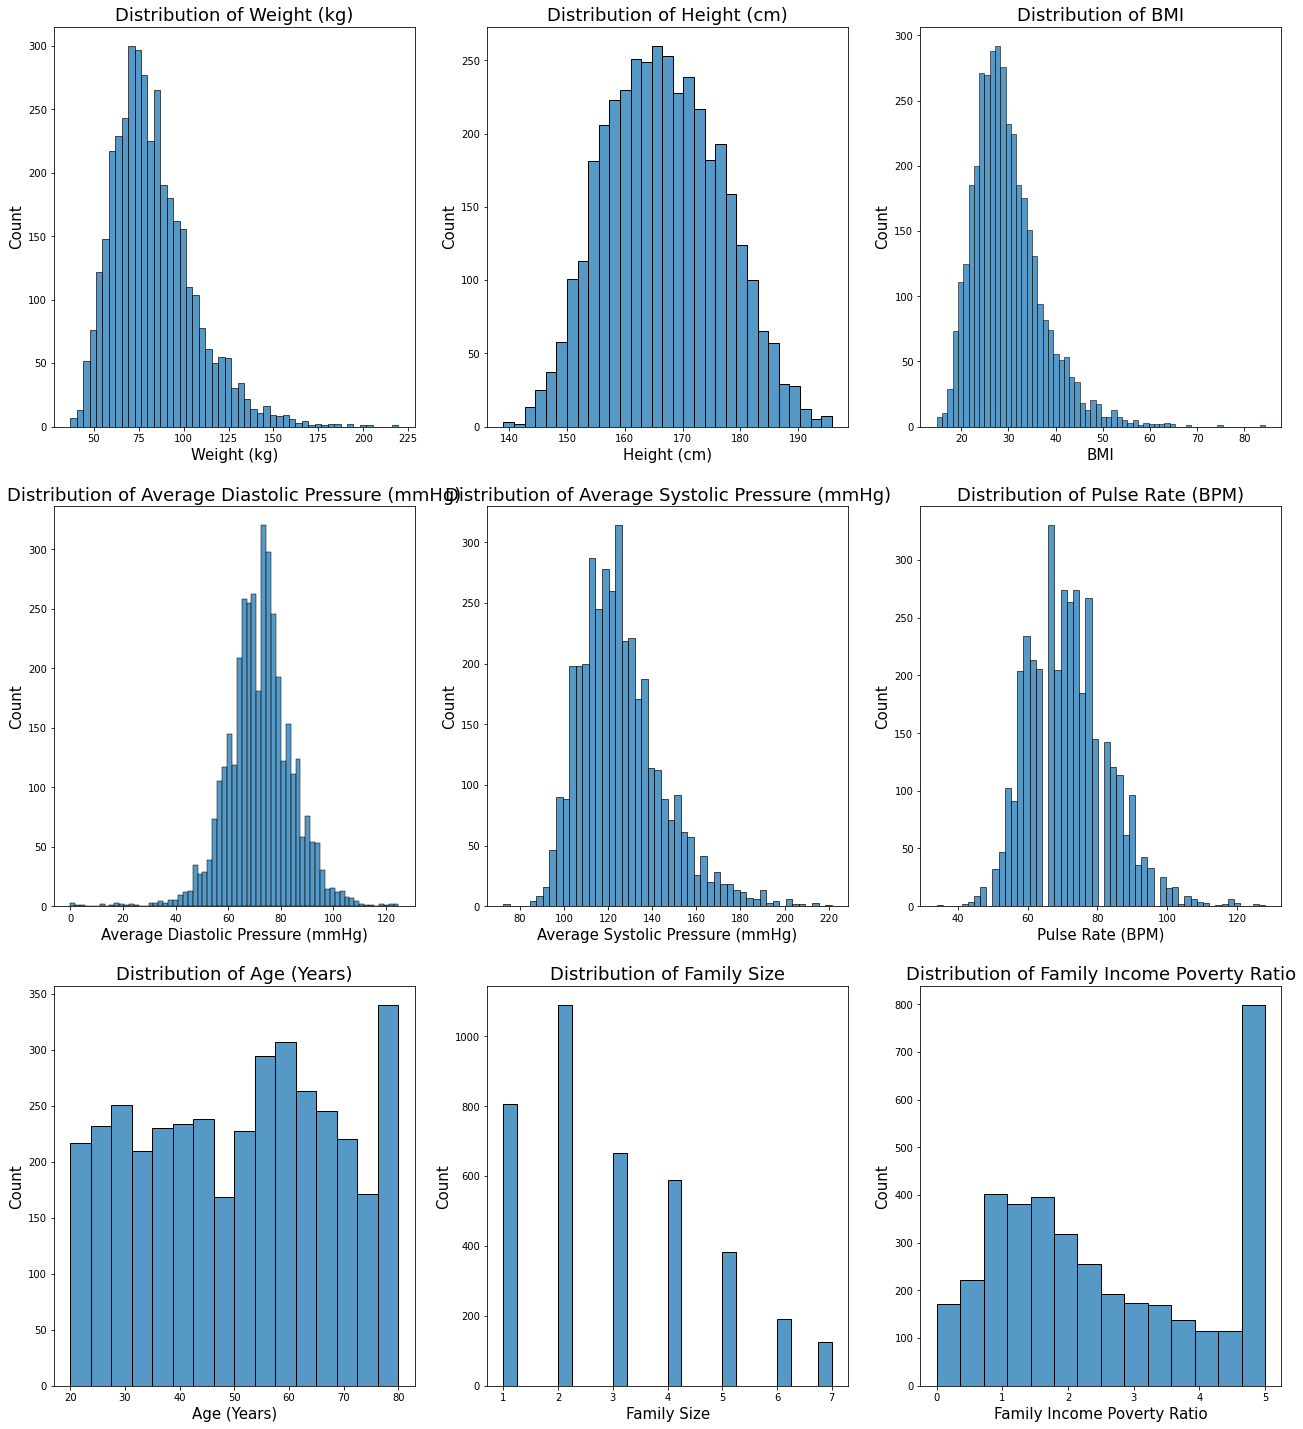

In [41]:
numerical = ['Weight', 'Height', 'BMI', 'diastolic_avg', 'systolic_avg', 'pulse_rate_BPM', 'Age',
        'FamilySize', 'FamilyIncomePovertyRatio']

categorical = ['Gender', 'Race', 'CountryOfBirth', 'CitizenshipStatus']
    
titles = ['Counts of Gender Categories', 'Counts of Race Categories', 'Counts of Country of Birth Categories', 'Counts of Citizenship Status Categories']
i = 0
# fig, ax = plt.subplots(3, 3, figsize=(22, 18))

# for variable in numerical:
#     axes = plt.hist()
#     axes = joined_dataset7[variable].hist(bins=15, figsize=(15, 10), layout=(3, 3));
#     axes.set_title(titles[i], size=18)
#     axes.set_xlabel(variable, size = 15)
#     axes.set_ylabel("Count", size = 15)
    

titles = ['Distribution of Weight (kg)', 
          'Distribution of Height (cm)',
          'Distribution of BMI',
          'Distribution of Average Diastolic Pressure (mmHg)',
          'Distribution of Average Systolic Pressure (mmHg)',
          'Distribution of Pulse Rate (BPM)',
          'Distribution of Age (Years)',
          'Distribution of Family Size',
          'Distribution of Family Income Poverty Ratio']
x_labels = ['Weight (kg)', 'Height (cm)', 'BMI', 'Average Diastolic Pressure (mmHg)', 
            'Average Systolic Pressure (mmHg)', 'Pulse Rate (BPM)', 'Age (Years)', 'Family Size', 'Family Income Poverty Ratio']
i = 0
fig, ax = plt.subplots(3, 3, figsize=(22, 25))
for variable, subplot in zip(numerical, ax.flatten()):
    axes = sns.histplot(x=joined_dataset7[variable], ax=subplot)
    axes.set_title(titles[i], size=18)
    axes.set_xlabel(x_labels[i], size = 15)
    axes.set_ylabel("Count", size = 15)
    i = i + 1
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

There are a lot of valuable insights contained in this data here, and we will briefly comment on each graph in turn. The 'Weight' graph follows a fairly normal distribution with a right skew, and looks standard. We can see that the 'Height' graph follows a very good normal distribution with no skew at all. The BMI skews to the right once again, with a normal looking distribution, and this makes sense, as it is simply made up of the height and weight variables, of which 'Weight' itself has the same skew. All the heart related variables look fairly normal. The 'Age' graph is interesting, showing that the participants are relatively uniformly selected from all age groups, although there are significantly more 60-64 and 76-80 year olds in the data. Family size shows us that most people only live with one other person, and the family income poverty ratio has a spike at the end as well. This is because values greater than 5 were coded as 5 for the purpose of preserving anonymity, so this is something to be aware of.

Next we can analyse the categorical variables

In [42]:
print("Types of 'Gender'")
print(joined_dataset7["Gender"].value_counts())
print("=======")
print("Types of 'Race'")
print(joined_dataset7["Race"].value_counts())
print("=======")
print("Types of 'CountryOfBirth'")
print(joined_dataset7["CountryOfBirth"].value_counts())
print("=======")
print("Types of 'CitizenshipStatus'")
print(joined_dataset7["CitizenshipStatus"].value_counts())
print("=======")

Types of 'Gender'
Female    1972
Male      1878
Name: Gender, dtype: int64
Types of 'Race'
Non-Hispanic White    1419
Non-Hispanic Black     863
Other Race             760
Mexican American       481
Other Hispanic         327
Name: Race, dtype: int64
Types of 'CountryOfBirth'
U.S.A.    2720
Other     1130
Name: CountryOfBirth, dtype: int64
Types of 'CitizenshipStatus'
Citizen        3368
Non-Citizen     482
Name: CitizenshipStatus, dtype: int64


As we saw earlier, we have six categorical columns with three being binary, 'Race' having 5 categories, and the remaining two having 12 categories each

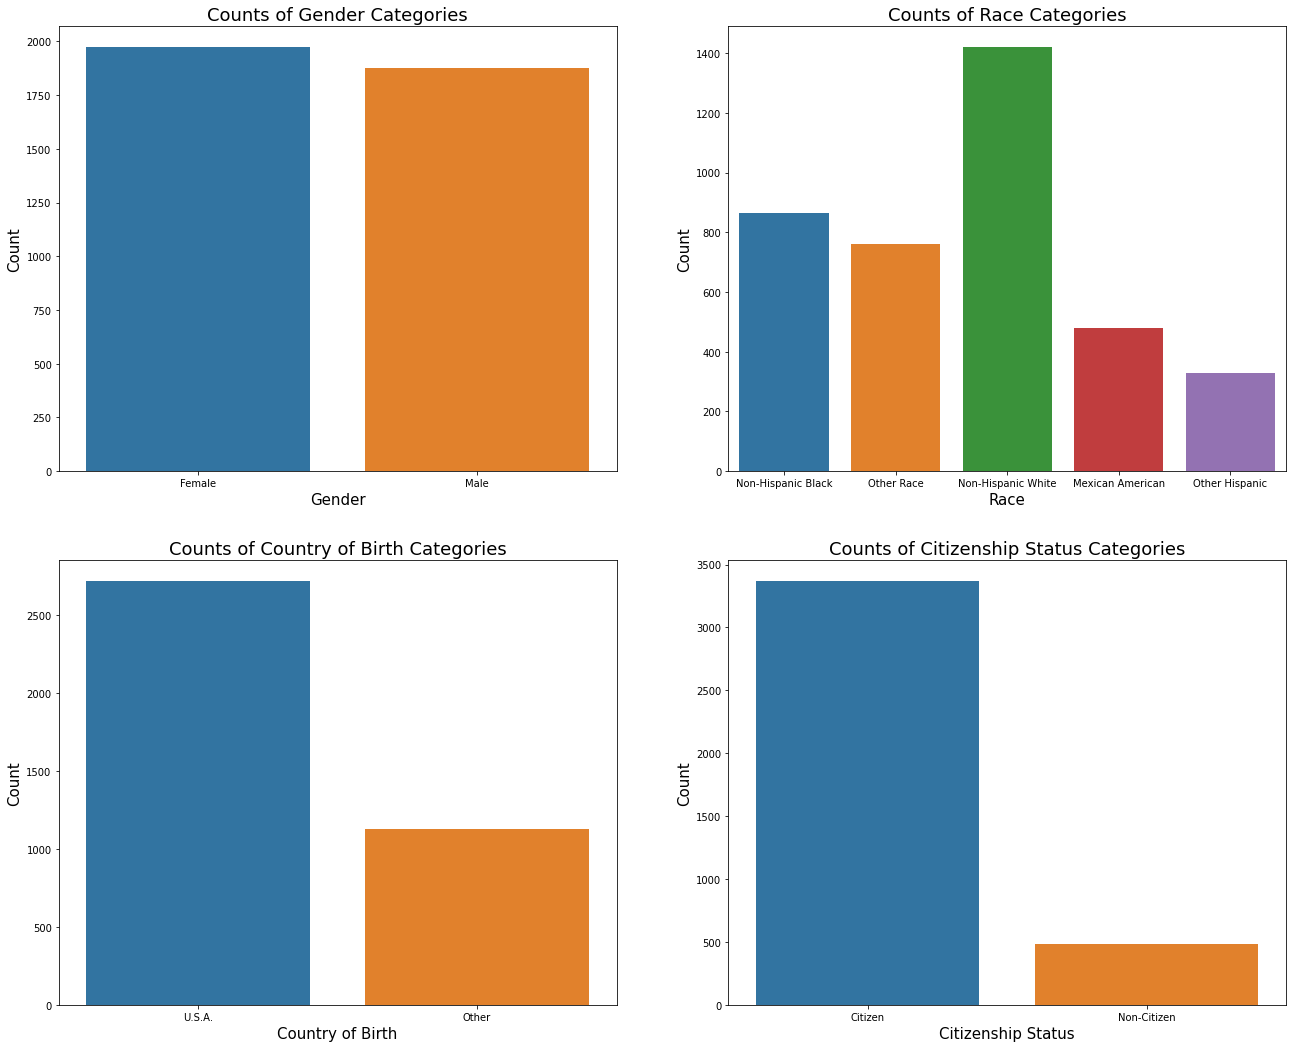

In [43]:
titles = ['Counts of Gender Categories', 'Counts of Race Categories', 'Counts of Country of Birth Categories', 'Counts of Citizenship Status Categories']
x_labels = ['Gender', 'Race', 'Country of Birth', 'Citizenship Status']
i = 0
fig, ax = plt.subplots(2, 2, figsize=(22, 18))
for variable, subplot in zip(categorical, ax.flatten()):
    axes = sns.countplot(x=joined_dataset7[variable], ax=subplot)
    axes.set_title(titles[i], size=18)
    axes.set_xlabel(x_labels[i], size = 15)
    axes.set_ylabel("Count", size = 15)
    i = i + 1
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

The gender looks fairly evenly split, with slightly more women than men taking part in the survey. We can see on the race graph that Non-Hispanic Whites (Category 3) make up the largest section of the survey, with Mexican Americans (1) and Other Hispanic (2) making up the smallest respective parts of the survey response group. The vast majority of those surveyed were born in the U.S.A., and an even larger proportion are U.S. citizens, suggesting that some of the people born in different countries gained U.S. citizenship

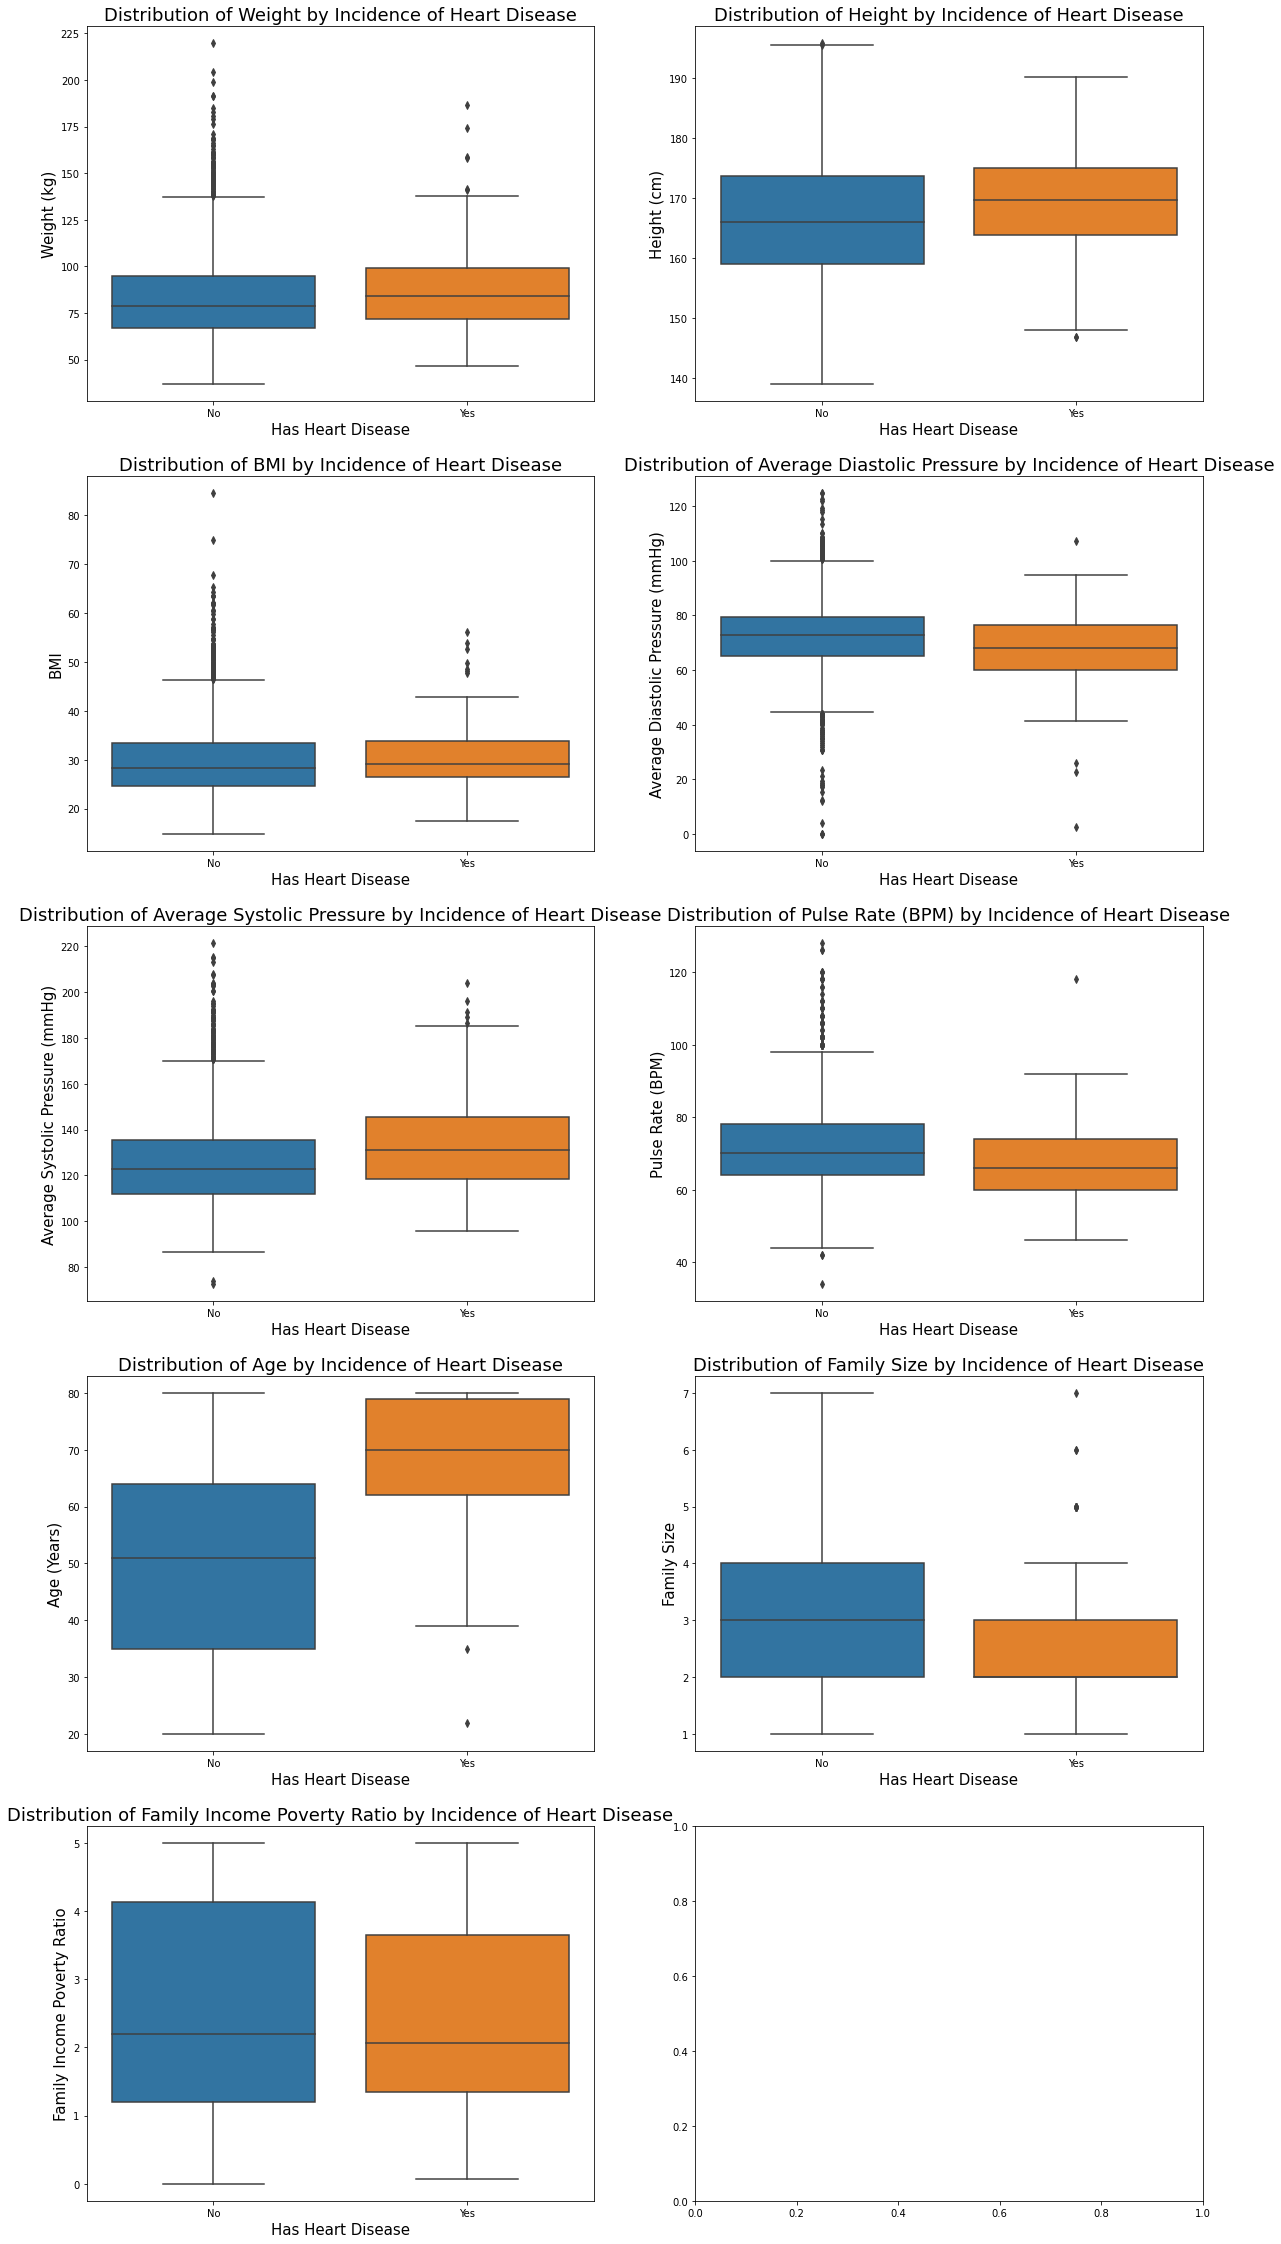

In [46]:
titles = ['Distribution of Weight by Incidence of Heart Disease', 
          'Distribution of Height by Incidence of Heart Disease',
          'Distribution of BMI by Incidence of Heart Disease',
          'Distribution of Average Diastolic Pressure by Incidence of Heart Disease',
          'Distribution of Average Systolic Pressure by Incidence of Heart Disease',
          'Distribution of Pulse Rate (BPM) by Incidence of Heart Disease',
          'Distribution of Age by Incidence of Heart Disease',
          'Distribution of Family Size by Incidence of Heart Disease',
          'Distribution of Family Income Poverty Ratio by Incidence of Heart Disease']
y_labels = ['Weight (kg)', 'Height (cm)', 'BMI', 'Average Diastolic Pressure (mmHg)', 
            'Average Systolic Pressure (mmHg)', 'Pulse Rate (BPM)', 'Age (Years)', 'Family Size', 'Family Income Poverty Ratio']
i = 0
fig, ax = plt.subplots(5, 2, figsize=(20, 40))
for var, subplot in zip(numerical, ax.flatten()):
    axes = sns.boxplot(x='hasHeartDisease', y=var, data=joined_dataset7, ax=subplot)
    axes.set_title(titles[i], size=18, wrap = True)
    axes.set_xlabel('Has Heart Disease', size = 15)
    axes.set_ylabel(y_labels[i], size = 15)
    i = i + 1
    

Here is the really interesting data, comparing the numerical categories against whether or not the person has been diagnosed with heart disease, with 1 representing yes and 2 representing no. Straight away we can see that the largest difference in the means of the boxplots comes from the 'Age' variable, with older people being significantly more likely to have heart disease. There are several other variables with differences, for instance 'Family Size'. This shows that people with lower family sizes are more likely to have heart disease. This is interesting, but correlation does not equal causation, so we cannot make inferences into this. Also people with lower annual household income appear to have a higher chance of having heart disease.

Plotting categorical variables against 'hasHeartDisease'

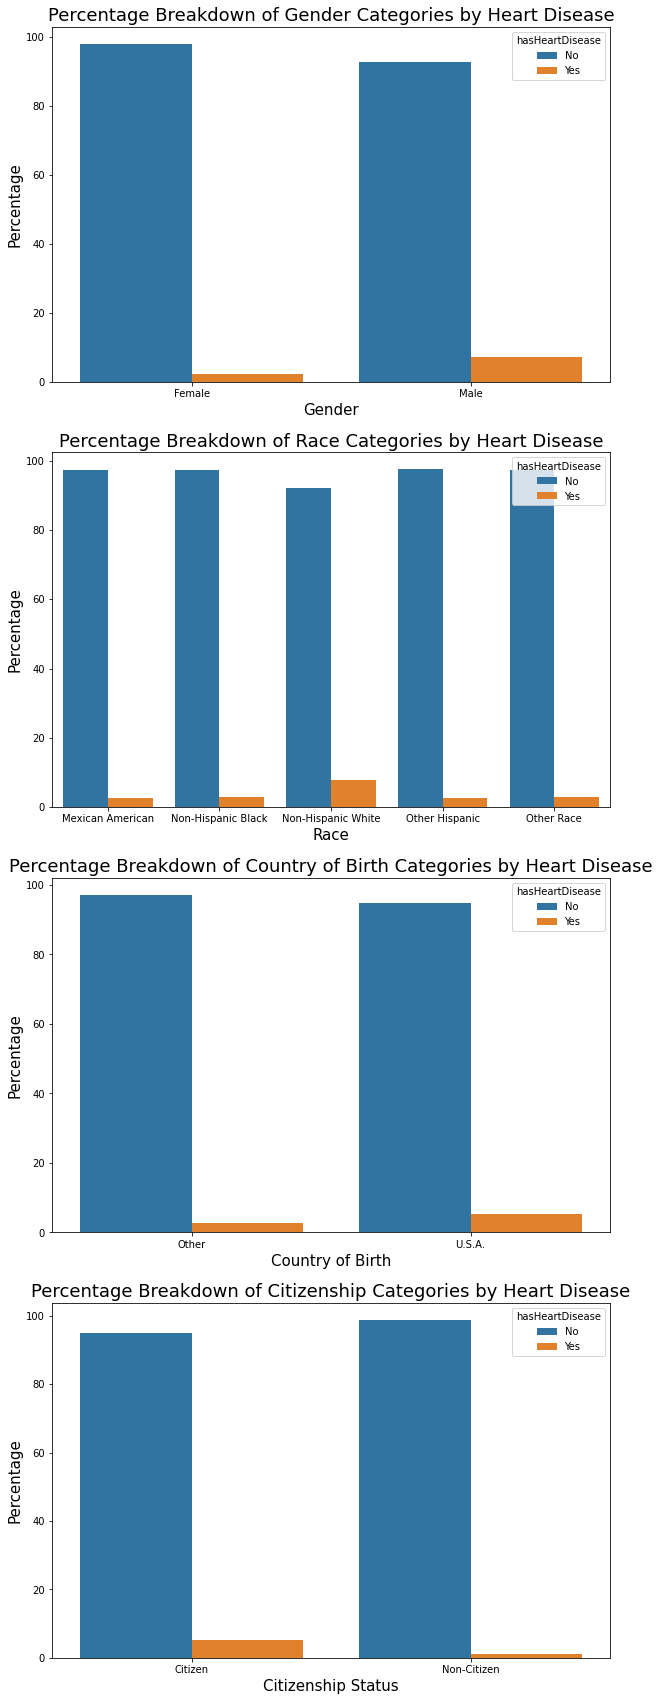

In [47]:
titles = ['Percentage Breakdown of Gender Categories by Heart Disease', 
          'Percentage Breakdown of Race Categories by Heart Disease',
          'Percentage Breakdown of Country of Birth Categories by Heart Disease', 
          'Percentage Breakdown of Citizenship Categories by Heart Disease']
x_labels = ['Gender', 'Race', 'Country of Birth', 'Citizenship Status']
i = 0
fig, ax = plt.subplots(4, 1, figsize=(10, 30))
y = 'hasHeartDisease'
for variable, subplot in zip(categorical, ax.flatten()):
    x = variable
    (joined_dataset7
    .groupby(x)[y]
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.barplot,'data'), x=x,y='percent',hue=y, ax=subplot))  
    subplot.set_title(titles[i], size=18, wrap = True)
    subplot.set_xlabel(x_labels[i], size = 15)
    subplot.set_ylabel("Percentage", size = 15)
    i = i + 1
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

Note that I have adjusted for actual counts by plotting percentage values. From this we can see that a larger percentage of men have heart disease than women, and heart disease is most common in Non-Hispanic Whites than it is in other races. Also it appears that people born in the U.S.A. and those who are citizens are more likely to have heart disease, although this could just be because the citizens and white people are more likely to go to doctors as they have higher incomes

Next we will resolve the class imbalance, by first oversampling the minority class and then undersampling the majority class

In order to do the oversampling, we need to point out which columns are actually categorical, otherwise the SMOTE will add new categories. We do this by providing a list of indexes, so we will take another look at the info

In [48]:
joined_dataset7.info()
joined_dataset7.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3850 entries, 6 to 8365
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weight                    3850 non-null   float64
 1   Height                    3850 non-null   float64
 2   BMI                       3850 non-null   float64
 3   diastolic_avg             3850 non-null   float64
 4   systolic_avg              3850 non-null   float64
 5   pulse_rate_BPM            3850 non-null   float64
 6   Gender                    3850 non-null   object 
 7   Age                       3850 non-null   float64
 8   Race                      3850 non-null   object 
 9   CountryOfBirth            3850 non-null   object 
 10  CitizenshipStatus         3850 non-null   object 
 11  FamilySize                3850 non-null   float64
 12  FamilyIncomePovertyRatio  3850 non-null   float64
 13  hasHeartDisease           3850 non-null   object 
dtypes: float

,Weight,Height,BMI,diastolic_avg,systolic_avg,pulse_rate_BPM,Gender,Age,Race,CountryOfBirth,CitizenshipStatus,FamilySize,FamilyIncomePovertyRatio,hasHeartDisease
6,88.8,151.1,38.9,66.666667,118.666667,74.0,Female,75.0,Non-Hispanic Black,U.S.A.,Citizen,1.0,0.41,No
7,62.1,170.6,21.3,66.666667,101.333333,62.0,Male,56.0,Other Race,Other,Citizen,3.0,5.00,No
9,74.9,178.6,23.5,72.000000,104.666667,90.0,Male,67.0,Non-Hispanic White,U.S.A.,Citizen,1.0,2.65,No
11,65.6,170.6,22.5,59.333333,114.000000,66.0,Male,71.0,Other Race,U.S.A.,Citizen,5.0,1.56,No
12,77.7,159.2,30.7,72.000000,120.666667,58.0,Male,61.0,Other Race,Other,Citizen,3.0,5.00,No


In [53]:
joined_dataset8 = joined_dataset7.copy()
joined_dataset8['hasHeartDisease'] = joined_dataset7['hasHeartDisease'].replace(['Yes', 'No'], [1, 0])

X = joined_dataset8.drop("hasHeartDisease", axis=1) # drop labels
y = joined_dataset8["hasHeartDisease"].copy() # save the labels

over = SMOTENC(categorical_features=[6, 8, 9, 10, ], random_state=0, sampling_strategy=0.3)

under = RandomUnderSampler(sampling_strategy=0.4)

steps = [('o', over), ('u', under)]

pipe = Pipeline(steps=steps)

X, y = pipe.fit_resample(X, y)

for c in np.unique(y):
    print('{%d : %d}' % (c, sum(y==c)))


#Merge them back together
balanced_dataset = X.copy()
balanced_dataset['hasHeartDisease'] = y
balanced_dataset.info()

{0 : 2752}
{1 : 1101}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3853 entries, 0 to 3852
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Weight                    3853 non-null   float64
 1   Height                    3853 non-null   float64
 2   BMI                       3853 non-null   float64
 3   diastolic_avg             3853 non-null   float64
 4   systolic_avg              3853 non-null   float64
 5   pulse_rate_BPM            3853 non-null   float64
 6   Gender                    3853 non-null   object 
 7   Age                       3853 non-null   float64
 8   Race                      3853 non-null   object 
 9   CountryOfBirth            3853 non-null   object 
 10  CitizenshipStatus         3853 non-null   object 
 11  FamilySize                3853 non-null   float64
 12  FamilyIncomePovertyRatio  3853 non-null   float64
 13  hasHeartDisease           3853 non-null  

Now we are finally ready to perform some machine learning on the data. For this dataset, we will use logistic regression with l1 regularization in order to determine the importance of the features. However we need to do some encoding as part of this process, normalising the numerical data and one-hot encoding the categorical data. Note that none of the categorical data is ordinal, so there is no need to use ordinal encoding on any of it


<b> We will now take the data in split it into both a training and a test set, with the split being an 80:20 split respectively with a random state of 0</b>

In [54]:
train_set, test_set = train_test_split(balanced_dataset, test_size=0.2, random_state=0)

In [55]:
train_set.head()

,Weight,Height,BMI,diastolic_avg,systolic_avg,pulse_rate_BPM,Gender,Age,Race,CountryOfBirth,CitizenshipStatus,FamilySize,FamilyIncomePovertyRatio,hasHeartDisease
1397,98.8,156.4,40.4,63.333333,131.333333,68.0,Female,80.0,Non-Hispanic White,U.S.A.,Citizen,2.0,1.79,0
338,75.3,181.0,23.0,94.666667,142.000000,88.0,Male,39.0,Non-Hispanic White,U.S.A.,Citizen,3.0,0.79,0
483,67.0,165.9,24.3,83.333333,136.666667,64.0,Male,58.0,Other Race,Other,Citizen,3.0,5.00,0
2876,78.5,164.5,29.0,70.666667,140.666667,76.0,Male,80.0,Non-Hispanic White,U.S.A.,Citizen,2.0,2.46,1
1819,78.9,170.9,27.0,71.333333,110.666667,106.0,Female,49.0,Non-Hispanic White,U.S.A.,Citizen,4.0,1.83,0


In [56]:
test_set.head()

,Weight,Height,BMI,diastolic_avg,systolic_avg,pulse_rate_BPM,Gender,Age,Race,CountryOfBirth,CitizenshipStatus,FamilySize,FamilyIncomePovertyRatio,hasHeartDisease
3183,158.240931,177.493572,50.333873,70.333858,110.999475,79.772083,Male,36.205440,Non-Hispanic White,U.S.A.,Citizen,3.0,0.832938,1
3699,90.081474,164.309263,33.377079,50.948538,100.525731,75.030877,Male,67.273158,Non-Hispanic White,U.S.A.,Citizen,1.0,1.430225,1
1703,90.200000,167.800000,32.000000,103.333333,157.333333,70.000000,Male,41.000000,Other Hispanic,U.S.A.,Citizen,2.0,5.000000,0
2821,77.900000,175.000000,25.400000,86.666667,122.000000,84.000000,Male,49.000000,Non-Hispanic White,U.S.A.,Citizen,7.0,1.190000,1
1051,75.000000,173.100000,25.000000,82.000000,118.666667,46.000000,Male,47.000000,Other Race,Other,Citizen,4.0,3.860000,0


### Preparing the data for machine learning

We will now start to transform the data into the appropriate formats to be used in our model

The first thing to do is to separate the data into the predictors and the target column (hasHeartDisease).

In [57]:
from sklearn.preprocessing import LabelEncoder
X_train = train_set.drop("hasHeartDisease", axis=1) # drop labels for the training set
y_train = train_set["hasHeartDisease"].copy() # save the labels

In [58]:
X_train.head(5)

,Weight,Height,BMI,diastolic_avg,systolic_avg,pulse_rate_BPM,Gender,Age,Race,CountryOfBirth,CitizenshipStatus,FamilySize,FamilyIncomePovertyRatio
1397,98.8,156.4,40.4,63.333333,131.333333,68.0,Female,80.0,Non-Hispanic White,U.S.A.,Citizen,2.0,1.79
338,75.3,181.0,23.0,94.666667,142.000000,88.0,Male,39.0,Non-Hispanic White,U.S.A.,Citizen,3.0,0.79
483,67.0,165.9,24.3,83.333333,136.666667,64.0,Male,58.0,Other Race,Other,Citizen,3.0,5.00
2876,78.5,164.5,29.0,70.666667,140.666667,76.0,Male,80.0,Non-Hispanic White,U.S.A.,Citizen,2.0,2.46
1819,78.9,170.9,27.0,71.333333,110.666667,106.0,Female,49.0,Non-Hispanic White,U.S.A.,Citizen,4.0,1.83


In [59]:
y_train.head(5)

1397    0
338     0
483     0
2876    1
1819    0
Name: hasHeartDisease, dtype: int64

Now we will transform all of the categorical data into numerical, and scale all of the numerical data. We do this by first making a transformation pipeline, so that we can then apply this same transformation to the test set later. Note that I have reproduced the numerical and categorical lists here for clarity

In [60]:
numerical_columns = ['Weight', 'Height', 'BMI', 'diastolic_avg', 'systolic_avg', 'pulse_rate_BPM', 'Age',
        'FamilySize', 'FamilyIncomePovertyRatio']
categorical_columns = ['Gender', 'Race', 'CountryOfBirth', 'CitizenshipStatus']


numerical_preprocessor = StandardScaler()
categorical_preprocessor = OneHotEncoder(sparse=False, handle_unknown="ignore")
preprocessor_v1 = ColumnTransformer([
    ('standard-scaler', numerical_preprocessor, numerical_columns),
    ('one-hot-encoder', categorical_preprocessor, categorical_columns)
])

Now we transform the training set

In [61]:
X_train_prepared = preprocessor_v1.fit_transform(X_train)
print("Shape of prepared data")
print(X_train_prepared.shape)
print("Shape of original data")
print(X_train.shape)

Shape of prepared data
(3082, 20)
Shape of original data
(3082, 13)


Note that the shape of the array has changed after the pipeline, as it encodes each categorical variable's options as a binary feature, increasing the total number of features to 22

### Training the model

Now the data is ready , we can train our model. We will use logistic regression, and tune its hyperparameters

In [62]:
lr_model_v1 = Pipeline([
    ('preprocessor', preprocessor_v1),
    ('classifier', LogisticRegression(max_iter=800, penalty='l1', solver='liblinear'))
])

lr_model_v1.fit(X_train, y_train)
y_train_predicted = lr_model_v1.predict(X_train)

print("Logistic Regression Accuracy:")
print(accuracy_score(y_train, y_train_predicted))

Logistic Regression Accuracy:
0.8549643088903309


An accuracy of 84% is good, and is low enough that the model doesn't appear to be overfitted on the training set

We will now use GridSearchCV to find the best hyperparameters for our model, then test it on the test set

In [63]:
param = {'classifier__C': [10**-3, 10**-2,10**-1,10**0,10**1,10**2, 10**3]}

grid_searchLR = GridSearchCV(estimator=lr_model_v1, param_grid=param)


grid_searchLR.fit(X_train, y_train)

y_train_predicted_GS = grid_searchLR.predict(X_train)

print("Logistic Regression Accuracy after Grid Search:")
print(accuracy_score(y_train, y_train_predicted_GS))

Logistic Regression Accuracy after Grid Search:
0.8559377027903958


The model showed no improvement after hyperparameter tuning, suggesting that it was already well tuned. This means that the default value of C is the best one there is

In [64]:
print("Logistic Regression best parameters")
print(grid_searchLR.best_params_)

Logistic Regression best parameters
{'classifier__C': 10}


We will then take what the best hyperparameters are and use them in our final model on the test set to determine a final accuracy

In [73]:
final_modelLR = grid_searchLR.best_estimator_

X_test = test_set.drop("hasHeartDisease", axis=1)
y_test = test_set["hasHeartDisease"].copy()

final_predictionsLR = final_modelLR.predict(X_test)
final_scoreLR = final_modelLR.predict_proba(X_test)[:,1]

print("Test set AUC:")
print(round(roc_auc_score(y_test, final_scoreLR), 3))
print("Test set Accuracy:")
print(100*round(accuracy_score(y_test, final_predictionsLR), 3))

Test set AUC:
0.909
Test set Accuracy:
84.6


The final accuracy on the test set of the logistic regression model is 86%. This is good and confirms my earlier claim that the model was not overfitted on the training set, actually performing slightly better on the test set

Now we will take a look at what features the model deemed to be important, and which ones were redundant

In [66]:
classifier = final_modelLR.named_steps['classifier']
preprocessor = final_modelLR.named_steps['preprocessor']

categorical_column_names = final_modelLR.named_steps['preprocessor'].transformers_[1][1].get_feature_names(categorical_columns)
numerical_column_names = numerical_columns
column_names = numerical_column_names.copy()
column_names.extend(categorical_column_names)

log_odds = classifier.coef_[0]
odds = np.exp(log_odds)
final_results = pd.DataFrame(odds, 
             column_names, 
             columns=['odds'])
# \.sort_values(by='odds', ascending=False)

print(final_results)

                                   odds
Weight                         2.308414
Height                         0.450647
BMI                            0.681304
diastolic_avg                  0.848463
systolic_avg                   1.117096
pulse_rate_BPM                 0.826758
Age                            3.709708
FamilySize                     1.228602
FamilyIncomePovertyRatio       0.947339
Gender_Female                  0.068755
Gender_Male                    1.000000
Race_Mexican American          0.769882
Race_Non-Hispanic Black        0.286955
Race_Non-Hispanic White        2.108237
Race_Other Hispanic            0.462063
Race_Other Race                1.000000
CountryOfBirth_Other           0.464597
CountryOfBirth_U.S.A.          1.000000
CitizenshipStatus_Citizen      1.000000
CitizenshipStatus_Non-Citizen  0.112796


C:\Users\hunua\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
